# K-Nearest Neighbors (KNN) Regression

In [17]:
import numpy as np
import scipy as sp
import scipy.stats as st
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['figure.figsize'] = (10, 5)

---
## Load diabetes standardized data set.

In [18]:
from sklearn import datasets
import pandas as pd

diabetes = datasets.load_diabetes()

X = diabetes.data
y = diabetes.target

# center y so we don't need to use a y-intercept in our model
y -= y.mean()
# standardize y to unit variance
y /= y.std()

features = "age sex bmi map tc ldl hdl tch ltg glu".split()
df = pd.DataFrame(X, columns=features)
df

,age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641
...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018118,0.044485
439,0.041708,0.050680,-0.015906,0.017282,-0.037344,-0.013840,-0.024993,-0.011080,-0.046879,0.015491
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044528,-0.025930


---
## KNN regression

In [19]:
from sklearn import neighbors

model = neighbors.KNeighborsRegressor(n_neighbors=3)
model.fit(X, y)
yfit = model.predict(X)
mse = np.mean((y - yfit)**2)

print("MSE K=3:", mse)

MSE K=3: 0.32956479444524583


## But how many neighbors should we consider? i.e. K = ?

---
## 1. Withhold a test set from the analysis. We'll use it only to test the prediction of the final model.

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((353, 10), (89, 10), (353,), (89,))

---
## 2. Use cross validation to determine the optimal number of nearest neighbors K to consider in the model.

In [21]:
from sklearn import neighbors
from sklearn.model_selection import cross_validate

Ks = np.arange(1, 101)  # [1, 2, ..., 100]
mse_train = np.zeros(Ks.shape)
mse_val = np.zeros(Ks.shape)
for i, K in enumerate(Ks):
    model = neighbors.KNeighborsRegressor(n_neighbors=K)
    results = cross_validate(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error', return_train_score=True)
    mse_train[i] = -results['train_score'].mean()
    mse_val[i] = -results['test_score'].mean()

idx = np.argmin(mse_val)
K = Ks[idx]
K

16

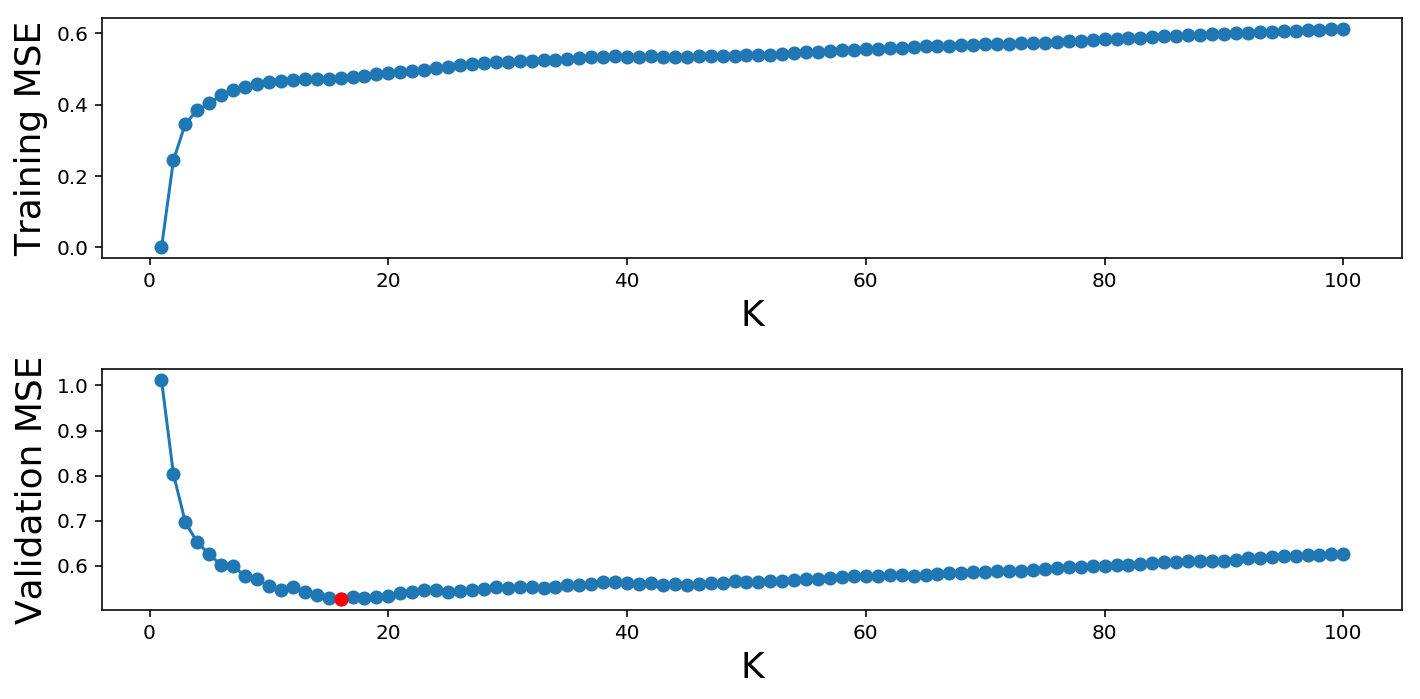

In [22]:
plt.subplot(211)
plt.plot(Ks, mse_train, 'o-')
plt.xlabel('K')
plt.ylabel('Training MSE')

plt.subplot(212)
plt.plot(Ks, mse_val, 'o-')
plt.xlabel('K')
plt.ylabel('Validation MSE')
plt.plot(K, mse_val[idx], 'ro')

plt.tight_layout();

---
## 3. Fit the entire training set using the model with the optimal number of nearest neighbors K and evaluate the model's error using the test set withheld in the beginning.

In [23]:
model = neighbors.KNeighborsRegressor(n_neighbors=16)
model.fit(X_train, y_train)

mse = np.mean( ( y_test - model.predict(X_test) )**2 )

print("MSE K=16:", mse)

MSE K=16: 0.5661295379593305


---
## Repeating step #2 using GridSearchCV

In [24]:
from sklearn.model_selection import GridSearchCV

params = {'n_neighbors': range(1, 101)}
knnmodel = neighbors.KNeighborsRegressor()
cvmodel = GridSearchCV(knnmodel, params, cv=10, scoring='neg_mean_squared_error')
cvmodel.fit(X_train, y_train)
cvmodel.best_params_['n_neighbors']

16